# Computer vision - Week_09 - Hough transform

In [1]:

import warnings
import numpy as np
from skimage import data, feature, filters
from skimage.transform import hough_line, probabilistic_hough_line
import matplotlib.pyplot as plt


plt.rc({'family' : 'normal', 'wight' : 'normal'})
plt.rcParams['font.size'] = 18
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category= RuntimeWarning)



What is Hough transform: The Hough Transform is a mathematical technique used in image processing and computer vision to detect and extract features, primarily for finding and identifying shapes and patterns within an image. It was originally developed by Paul Hough in 1962 and has since been extended and refined for various applications.

The Hough Transform is commonly used for the detection of lines and other parametric shapes in an image. Here's a simplified explanation of how it works for line detection

Input: Binary image (after edge detection)
Output: Mathematical parameters of founding shapes.

[To read](https://medium.com/@tomasz.kacmajor/hough-lines-transform-explained-645feda072ab)
Explain + OpenCV ready to use implementation [Page](https://www.scaler.com/topics/hough-transform-in-image-processing/)

## Analytical solution in "continuous" space


Example of finding line parameters for three points in 2D space.

### Add points

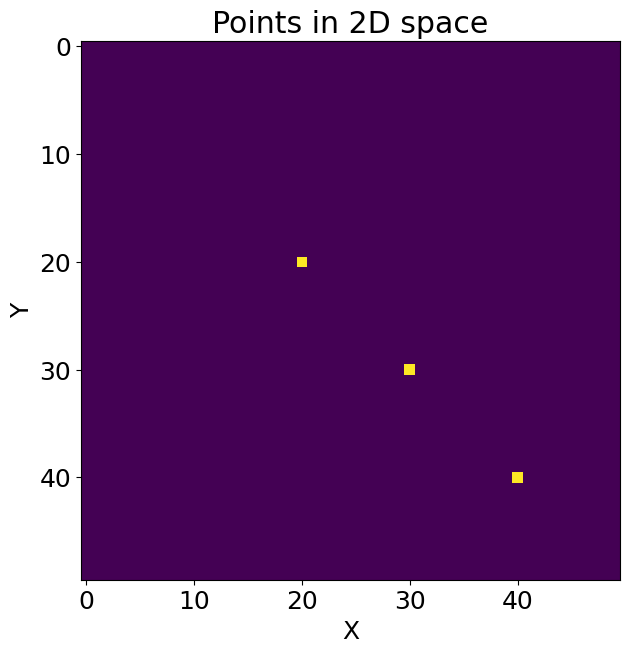

In [2]:
# Create a 50x50 binary image initialized with zeros - our playground
zero = np.zeros((50, 50), dtype=np.bool_)

# Set a few points in the image to 1
zero[20, 20] = 1
zero[30, 30] = 1
zero[40, 40] = 1
# You can uncomment the following line to set another point to 1 - point not align to result line of first 3 points
# zero[10, 40] = 1

# Create a plot for displaying the image
plt.figure(figsize=(10, 7))
plt.title("Points in 2D space")
plt.xlabel('X')
plt.ylabel('Y')

# Display the binary image using imshow
plt.imshow(zero)

### Create possible thetas

![image info](_data/line_eq.jpg)
OR `rho = x * cos(theta) + y * sin(theta)`
- rho (ρ) represents the distance from the origin (0,0) to the closest point on a straight line that passes through the point
- (x, y) and makes an angle θ (theta) with the positive x-axis. In the context of the Hough Transform, ρ is a parameter used to represent a line in polar coordinates.
x and y are the coordinates of a point in a Cartesian coordinate system. These are the coordinates of the point you're trying to represent as part of a line in the Hough Transform.
- theta (θ) represents the angle between the line and the positive x-axis, as mentioned above. In the Hough Transform, θ is another parameter used to represent a line.


In [3]:
# Create an array 'theta' representing a range of values from 0 to π with a step of 0.02
theta = np.arange(0, np.pi, 0.02)

# Print the number of values in the 'theta' array
print("Theta contain: " + str(theta.size) + " values.")

Theta contain: 158 values.


### Calc rho

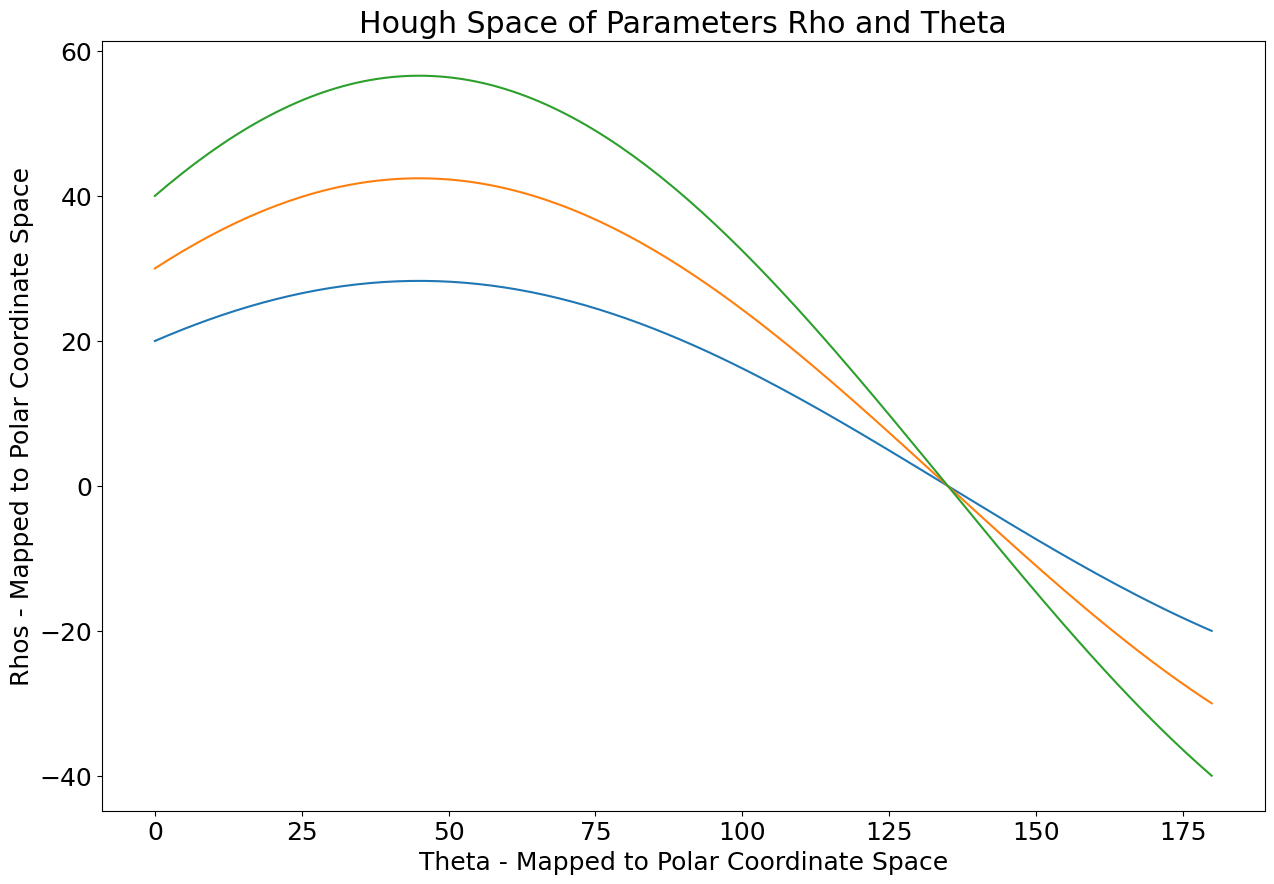

In [4]:
# Given a binary image 'zero', find the coordinates of points with a value of 1
x, y = np.where(zero == 1)

# Create a figure for plotting
plt.figure(figsize=(15, 10))

# Create an empty list to store rho values
rhoStack = []

# Iterate through each of the identified points
for i in range(0, x.size):
    # Calculate rho values for different theta values
    rhos = x[i] * np.cos(theta) + y[i] * np.sin(theta)

    # Append the calculated rho values to the 'rhoStack'
    rhoStack.append(rhos)

    # Plot the rho values as a function of theta (Hough space representation)
    plt.plot(np.rad2deg(theta), rhos)

# Set the title and labels for the plot
plt.title("Hough Space of Parameters Rho and Theta")
plt.xlabel("Theta - Mapped to Polar Coordinate Space")
plt.ylabel("Rhos - Mapped to Polar Coordinate Space")

# Display the plot
plt.show()

In [5]:
if zero[10, 40] == 0:
    input("Go back and add another point (for preview) -> only uncomment row :)")

### Find theta and visualise line
The code converts the 'rhoStack' list into a NumPy array for more convenient numerical operations.
It calculates the absolute differences (discrepancies) between the rho values for different pairs of points, resulting in 'r1', 'r2', and 'r3'.
The code finds the index where the sum of the differences 'r1 + r2 + r3' is minimized, representing the best-fit line.
It retrieves the winning rho and theta values based on the minimum difference and displays them as the detected line parameters.
The code calculates the coordinates of the detected line using the rho and theta values.
A new figure is created for visualization, and the binary image is displayed.
The detected line is plotted on the image for visualization.

We found a suitable line with parameters: Rho: [[-0.10763581]] pixels and Theta: [135.21803965] degrees


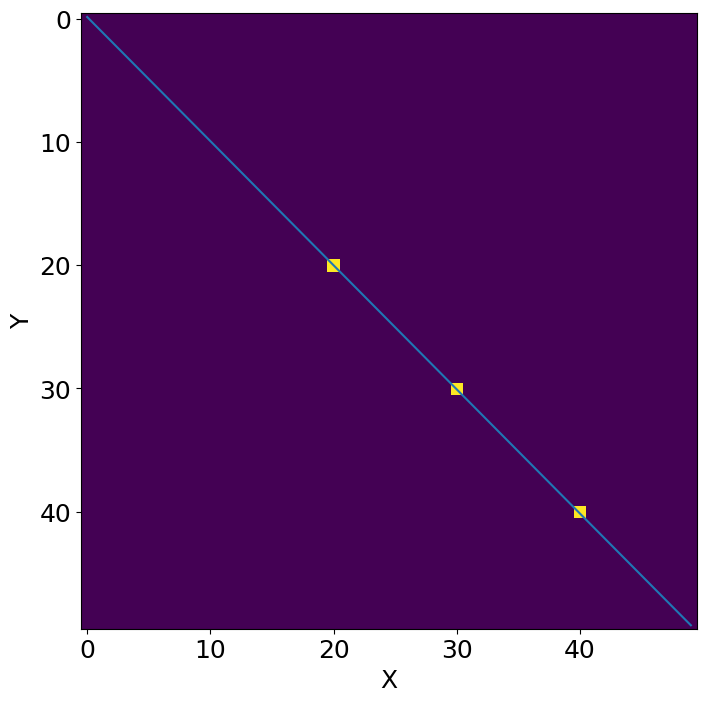

In [6]:
# Convert the list 'rhoStack' to a NumPy array for easier manipulation
rhoStack = np.array(rhoStack)

# Calculate absolute differences between rho values for different pairs of points
r1 = np.abs(rhoStack[0, :] - rhoStack[1, :])
r2 = np.abs(rhoStack[0, :] - rhoStack[2, :])
r3 = np.abs(rhoStack[1, :] - rhoStack[2, :])

# Find the index of the minimum sum of differences (r1 + r2 + r3)
minDif = np.where((r1 + r2 + r3) == np.min(r1 + r2 + r3))

# Get the winning rho and theta values based on the minimum difference
rhoWinner = rhoStack[0, minDif]
thetaWinner = theta[minDif]

# Display the detected line parameters
print("We found a suitable line with parameters: Rho: {} pixels and Theta: {} degrees".format(rhoWinner, np.rad2deg(thetaWinner)))

# Calculate the coordinates of the detected line
lineX = np.array([[0, zero.shape[1] - 1]])
lineY = (-np.cos(thetaWinner) / np.sin(thetaWinner)) * lineX + rhoWinner / np.sin(thetaWinner)

# Create a new figure for visualization
plt.figure(figsize=(8, 8))
plt.xlabel('X')
plt.ylabel('Y')
# Display the binary image
plt.imshow(zero)

# Plot the detected line on the image
plt.plot(lineX.ravel(), lineY.ravel())

##  Solution in "discrete" space

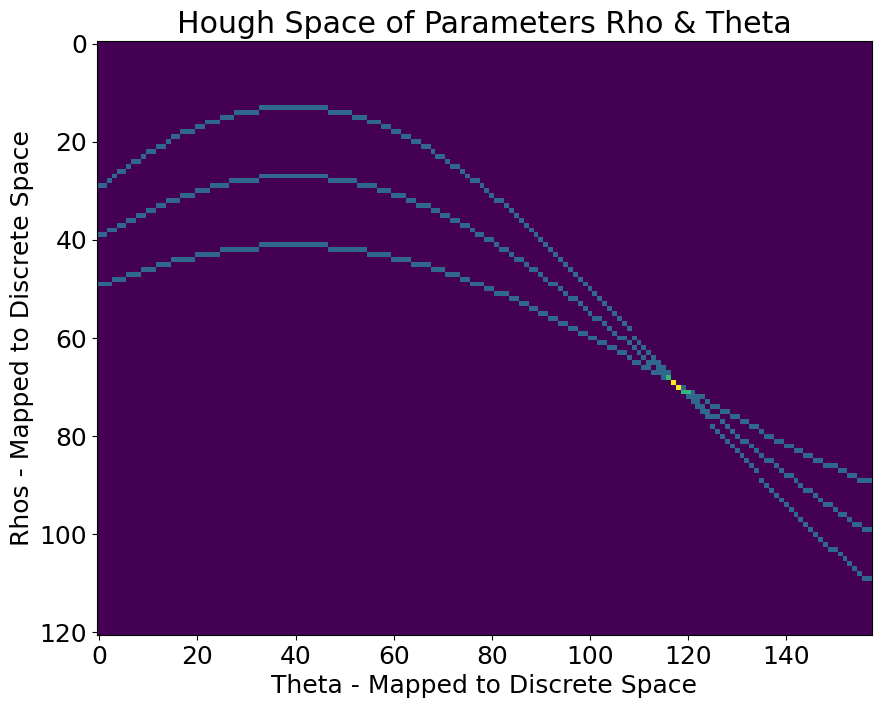

In [7]:
# Define a range of theta values in discrete steps
theta = np.arange(0, np.pi, 0.02)

# Create an empty list 'accumulator' to store rho values for each point
accumulator = []

# Iterate through the identified points
for i in range(0, 3):
    # Calculate rho values for different theta values for each point
    rhos = x[i] * np.cos(theta) + y[i] * np.sin(theta)

    # Append the calculated rho values to the 'accumulator'
    accumulator.append(rhos)

# Convert 'accumulator' list to a NumPy array for easier manipulation
accumulator = np.array(accumulator)

# Calculate the maximum possible rho value 'D' based on the image size
D = np.sqrt(zero.shape[0] ** 2 + zero.shape[1] ** 2)

# Create an array 'rhoRange' representing discrete rho values
rhoRange = np.arange(-zero.shape[1], D, 1)

# Initialize an empty Hough space matrix filled with zeros
houghSpace = np.zeros((rhoRange.size, theta.size))

# Iterate through each theta value
for i in range(0, theta.size):
    # Extract the rho values for the current theta
    rhoVals = accumulator[:, i]

    # Calculate a histogram of rho values within the specified 'rhoRange'
    yHist, xHist = np.histogram(rhoVals, rhoRange)

    # Fill the corresponding column in the Hough space with the histogram values
    houghSpace[:houghSpace.shape[0] - 1, i] = np.flipud(yHist)

# Create a figure for visualizing the Hough space
plt.figure(figsize=(10, 10))
plt.title('Hough Space of Parameters Rho & Theta')
plt.xlabel('Theta - Mapped to Discrete Space')
plt.ylabel('Rhos - Mapped to Discrete Space')

# Display the Hough space as an image
plt.imshow(houghSpace)


In [8]:
# Find the maximum value (peak) in the Hough space
max_hough = np.max(houghSpace)

# Find the coordinates (x, y) of the maximum value in the Hough space
x, y = np.where(houghSpace == max_hough)

# Translate the coordinates (x, y) to the corresponding theta and rho values
# The maximum value in Hough space corresponds to the detected line
theta_winner = theta[y[1]]
rho_winner = rhoRange[rhoRange.size - x[1]]

# Display the detected line parameters
print("We found a fitting line with parameters: Rho: {} pixels and Theta: {} degrees".format([rho_winner], np.rad2deg(theta_winner)))

We found a fitting line with parameters: Rho: [1.0] pixels and Theta: 135.2180396508743 degrees


## Rectangle example
### Create rectangle

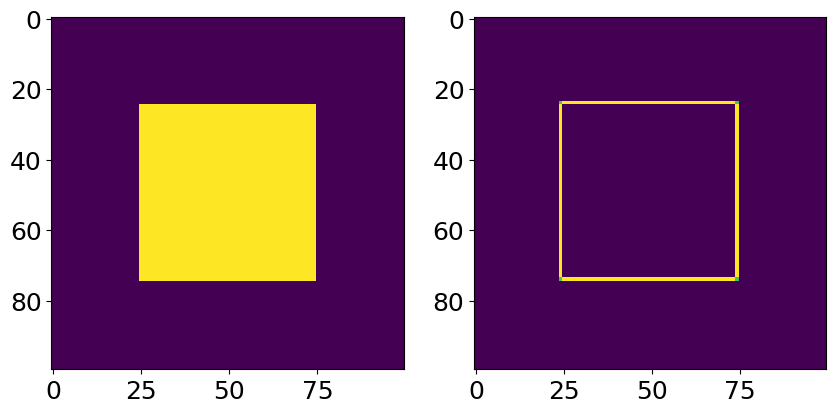

In [9]:
# Create a 100x100 numpy array initialized with zeros
zeros = np.zeros((100, 100))

# Draw a white rectangle in the center of the image
zeros[25:75, 25:75] = 255

# Create a figure for displaying images
plt.figure(figsize=(10, 10))

# Subplot 1: Display the original image with the rectangle
plt.subplot(121)
plt.imshow(zeros)

# Subplot 2: Apply a filter (Roberts filter) to the image and display the result
zeros = filters.roberts(zeros)
plt.subplot(122)
plt.imshow(zeros)

# Show the figure with both images
plt.show()


### Implement algorithm

Begins by determining the dimensions of the 'zeros' image and calculating the maximum possible rho value 'D' based on these dimensions.
Arrays 'thetas' and 'rhos' are created to represent the discrete steps for theta and rho values in the Hough space.
An empty Hough space matrix 'houghSpace' is initialized with zeros, ready to accumulate votes.
The code identifies the non-zero pixel coordinates (x, y) in the 'zeros' image.
An accumulator is created to calculate the Hough space values efficiently based on matching x, y coordinates with cosine and sine values.
Histograms of rho values are computed for each theta, and the Hough space is filled accordingly.
A Matplotlib figure with two subplots is created for visualization. Subplot 1 shows the entire Hough space, and Subplot 2 displays values above the 99th percentile threshold.

Text(0, 0.5, 'Rhos')

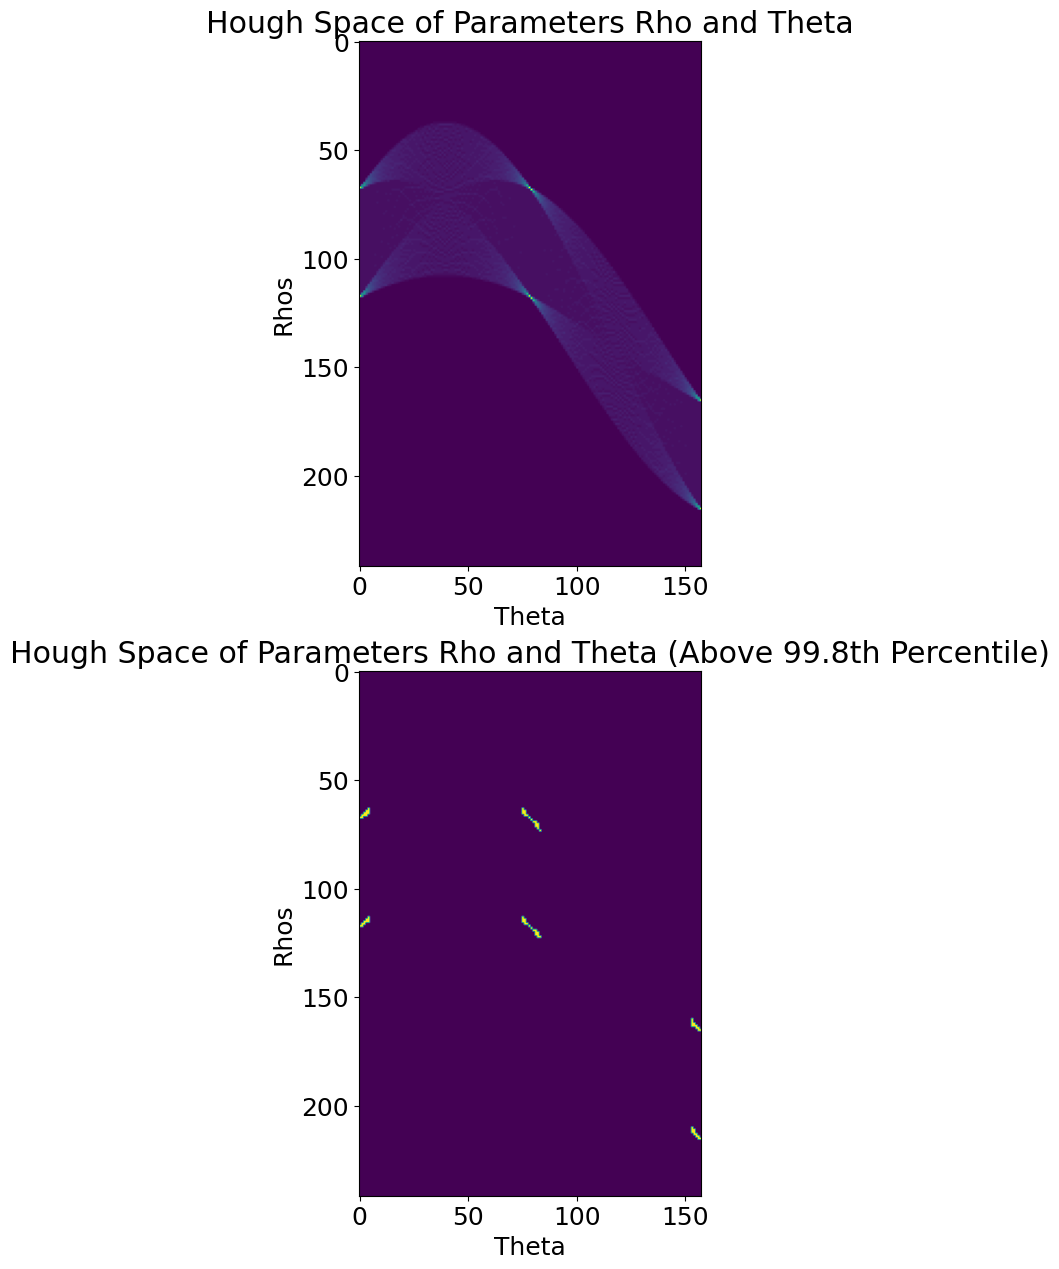

In [10]:
# Get the dimensions of the 'zeros' image (width and height)
width, height = zeros.shape

# Calculate the maximum possible rho value 'D' based on the image dimensions
D = (height**2 + width**2) ** 0.5

# Create arrays for theta values and rho values with discrete steps
thetas = np.arange(0, np.pi, 0.02)
rhos = np.arange(-width, D, 1)

# Initialize an empty Hough space matrix filled with zeros
houghSpace = np.zeros((rhos.size, thetas.size))

# Find the coordinates (x, y) where pixel values are greater than 0 (non-zero values)
x, y = np.where(zeros > 0)

# Create an accumulator to calculate the Hough space values
accumulator = np.zeros((x.size, thetas.size))

# Calculate cosine and sine values for different thetas and x, y coordinates
cosVals = np.matmul(np.expand_dims(np.arange(0, width, 1), axis=0).T,
                    np.expand_dims(np.cos(thetas), axis=0))
sinVals = np.matmul(np.expand_dims(np.arange(0, height, 1), axis=0).T,
                    np.expand_dims(np.sin(thetas), axis=0))

# Find matching x and y coordinates based on cosine and sine values
xMatch = cosVals[x, :]
yMatch = sinVals[y, :]

# Calculate the accumulator values by adding xMatch and yMatch
accumulator[:, :] = xMatch + yMatch

# Initialize an array to store histograms of rho values for each theta
# These histograms will be used to populate the Hough space
for i in range(0, thetas.size):
    rhoVals = accumulator[:, i]
    yHist, xHist = np.histogram(rhoVals, rhos)
    houghSpace[1:, i] = np.flipud(yHist)

# Create a Matplotlib figure for visualization
plt.figure(figsize=(25, 15))

# Subplot 1 (211): Display the Hough space
plt.subplot(211)
plt.imshow(houghSpace)
plt.title('Hough Space of Parameters Rho and Theta')
plt.xlabel('Theta')
plt.ylabel('Rhos')

# Subplot 2 (212): Display the Hough space with values above the 99th percentile threshold
plt.subplot(212)
plt.imshow(houghSpace > np.percentile(houghSpace, 99.8))
plt.title('Hough Space of Parameters Rho and Theta (Above 99.8th Percentile)')
plt.xlabel('Theta')
plt.ylabel('Rhos')

## Real image experiment
(implement build in functions)
Code loads an example image (in this case, 'camera') for testing line detection.
Two subplots in the first Matplotlib figure display the original image and the edges detected using the Canny edge detection algorithm.
A second figure is created to visualize the Hough space after applying the Hough Line Transform to the edge image.
The probabilistic Hough Line Transform is then used to detect and mark lines in both the original image and the edge image, displaying the results in two subplots.
The 'real_image' variable is used to hold the loaded image, which is more meaningful than 'circuit' in this context.

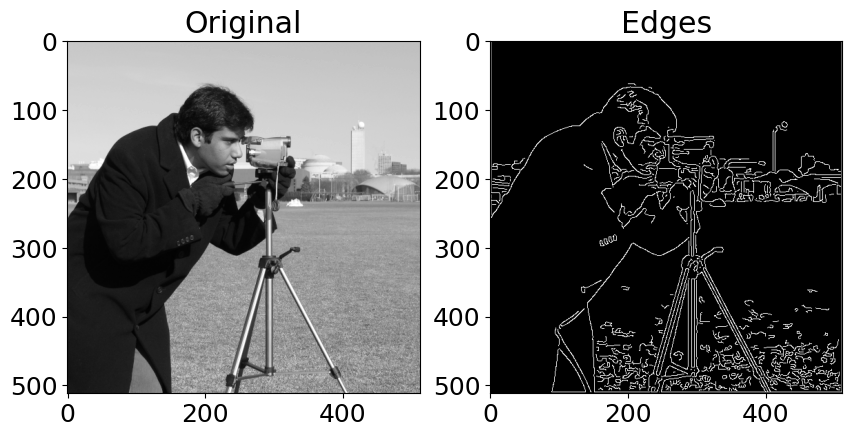

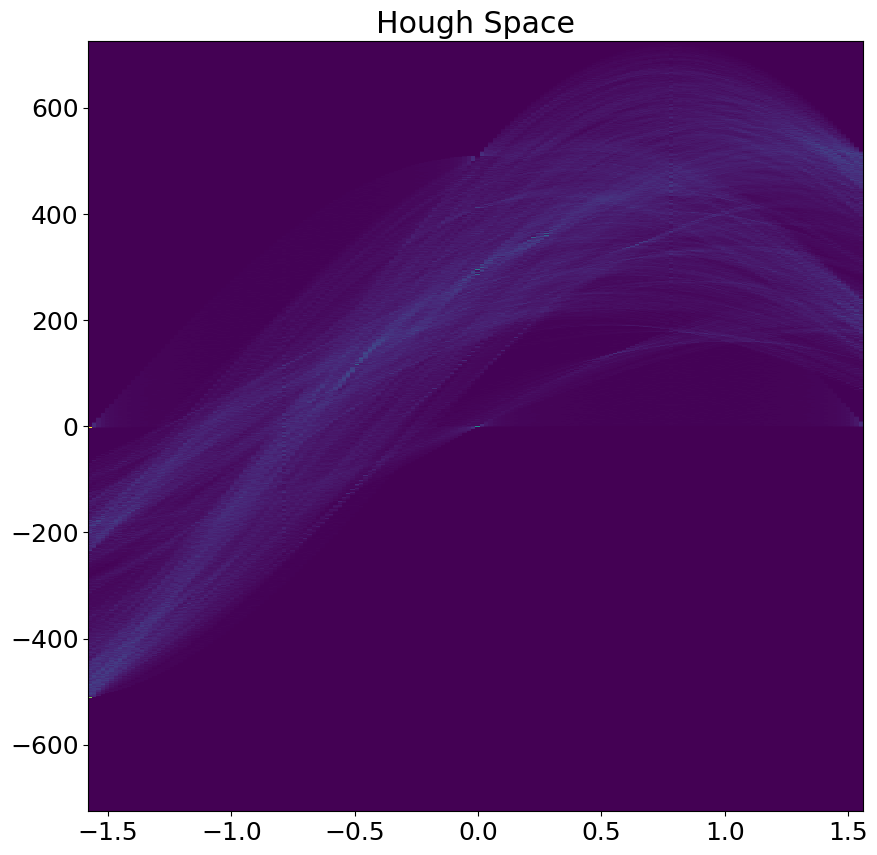

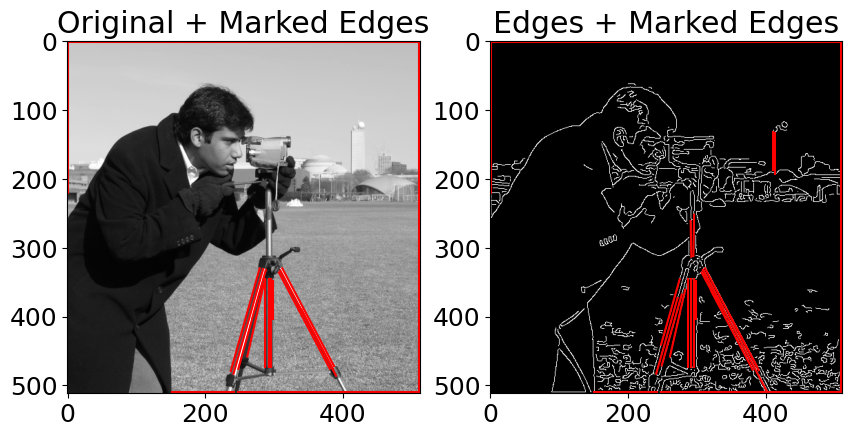

In [11]:
# Load a sample image (in this case, the 'camera' image)
real_image = data.camera()

# Create a Matplotlib figure for displaying images
plt.figure(figsize=(10, 10))

# Subplot 1 (121): Display the original image
plt.subplot(121)
plt.title('Original')
plt.imshow(real_image, cmap='gray')

# Subplot 2 (122): Apply the Canny edge detection algorithm to the image
plt.subplot(122)
plt.title('Edges')
edges = feature.canny(real_image, sigma=1.4)
plt.imshow(edges, cmap='gray')

# Create a new Matplotlib figure for visualizing the Hough space
plt.figure(figsize=(10, 10))
plt.title('Hough Space')

# Apply the Hough Line Transform to detect lines in the edge image
accumulator, angles, dists = hough_line(edges)

# Display the Hough space using pcolor
plt.pcolor(angles, dists, accumulator)
# plt.xlabel('Theta')
# plt.ylabel('Rhos')

# Create a Matplotlib figure for displaying the marked edges and lines
plt.figure(figsize=(10, 10))

# Subplot 1 (121): Display the original image with marked edges
plt.subplot(121)
plt.title('Original + Marked Edges')
lines = probabilistic_hough_line(edges, threshold=100, line_length=50, line_gap=1)
plt.imshow(real_image, cmap='gray')

# Plot the detected lines on the original image
for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]), 'r-')

# Subplot 2 (122): Display the edge image with marked edges
plt.subplot(122)
plt.title('Edges + Marked Edges')
lines = probabilistic_hough_line(edges, threshold=50, line_length=50, line_gap=1)
plt.imshow(edges, cmap='gray')

# Plot the detected lines on the edge image
for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]), 'r-')

# Show the Matplotlib figures
plt.show()
